# CCD spectrometer
* ## Background
* ## Ethanol

All counts are transformed to rates. 
Background is then subtracted. 

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [2]:
import re
from scipy.constants import c,h,eV, pi
hceV = h * c  /eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./npy/"
        
xlim_global = (420, 620)

In [3]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

def double_breit_wigner(x, x0, gamma, amplitude, x0_2, gamma_2, amplitude_2, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    f_x = amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + \
        amplitude_2 / ((pi*gamma_2) * (1 + ((x - x0_2) / gamma_2)**2)) + \
        offset
    return(f_x)
    
def double_bw_fit(x, y, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(double_breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = double_breit_wigner(x_fit, *coeff)
    else:
        fit_peak = double_breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

def poly4_fit(x_fit, y_fit, y_e, p0):
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))

In [8]:
def uc_str(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

## Background

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


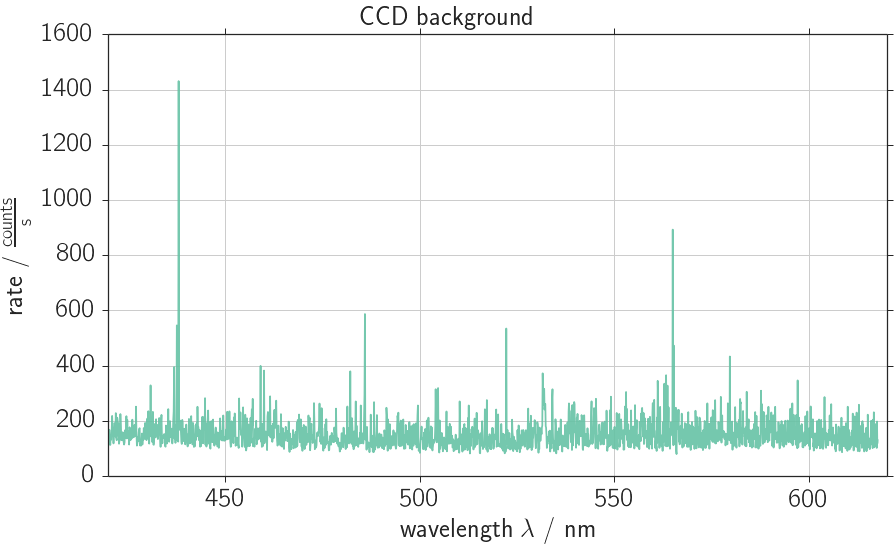

In [9]:
#### Background ####
filename = "ccd_bg_30_10"

# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

rate_bg = y / t
rate_bg_e = y_e / t

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD background')
ax.plot(x, rate_bg, "-", alpha = 0.9)
ax.set_xlim(xlim_global)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
#ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_background"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


(557.9835876939857+/-0.001413054410317286, 0.40230988279322216+/-0.002476256425319727, 186.9360438051475+/-0.9855650618893245, -3.56652945792153+/-0.16606104836699195)


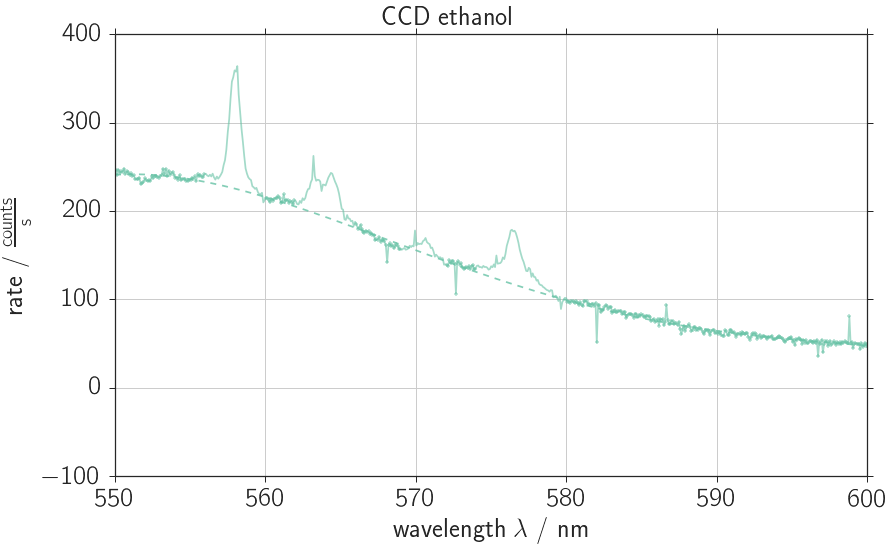

In [225]:
concentration = [0, 10, 20, 30, 40, 60, 70, 80, 100]
#concentration = [40]
concentration = [30]
"data/ccd_et_"

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD ethanol')

#### Ethanol ####
for conc_i in concentration:
    filename = "ccd_et_" + str(conc_i)

    # Get integration time and number of measurements
    f = open("data/" + filename + ".txt", encoding='cp1252')
    lines = f.readlines()
    f.close()
    t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
    avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

    # Data
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    
    y = y / t - rate_bg
    y_e = y_e / t - rate_bg_e
    
    # remove outliers, identified by largest absolute value 
    # of difference between point and its two neighbours.
    for i in range(4):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        #print(x[out], y[out])
        x, y = np.delete([x, y], out, 1)
    data_points, = ax.plot(x, y, "-", alpha = 0.6, label=str(conc_i) + '\%')
    
    # identify peaks
    x_peaks = np.array([[556, 560], [562, 566], [569, 572], [574, 580]])
    where_peaks = [(x_low < x) * (x < x_high) for x_low, x_high in x_peaks]
    mask_peak = np.where(sum(where_peaks) == 0)[0]
    x_p = x[mask_peak]
    y_p = y[mask_peak]
    ax.plot(x_p, y_p, ".", alpha = 0.5, c=data_points.get_color(), label=str(conc_i) + '\%')
    
    # fit from 550 - 590 nm w/out peaks
    x_fit_min, x_fit_max = [550,  600]
    mask_fit = (x_fit_min < x_p) * (x_p < x_fit_max)
    p = np.polyfit(x_p[mask_fit], y_p[mask_fit], 4)
    x_poly = np.linspace(x_fit_min, x_fit_max, 200)
    ax.plot(x_poly, np.polyval(p, x_poly), "--", alpha = 0.8, 
            c=data_points.get_color(), label=str(conc_i) + '\%')
    
    # Peak fit: Data - polyfit
    mask = (x_fit_min < x) * (x < x_fit_max)
    x_fit = x[mask]
    y_fit = y[mask] - np.polyval(p, x_fit)
    #ax.plot(x_fit, y_fit, "-", alpha = 0.6, label=str(conc_i) + '\%')
    
    x_range = [554, 561]   # lower and upper bound
    p0 = np.array([558, 0.2, 100, 0])
    x_fit1, fit_peak1, c1 = bw_fit(x_fit, y_fit, y_e, x_range, p0, fit=True)
    #ax.plot(x_fit1, fit_peak1, "-", label='435.8 nm')
"""   
    # Fitting
# p = [x0, gamma, amplitude, offset]
###### PEAK 1 #################
# Define range to be fitted
x_range = [420, 450]   # lower and upper bound
p0 = np.array([435, 0.2, 14000, 0])
x_fit1, fit_peak1, c1 = bw_fit(x, y, y_e, x_range, p0, fit=True)

###### PEAK 2 & 3 #################
# Define range to be fitted
x_range = [520, 560]   # lower and upper bound
p0 = np.array([545, 0.2, 40000, 0])
x_fit2, fit_peak2, c2 = double_bw_fit(x, y, y_e, x_range, p0, fit=True)

###### PEAK 4 #################
# Define range to be fitted
x_range = [578, 585]   # lower and upper bound
p0 = np.array([579, 0.2, 5000, 0])
x_fit4, fit_peak4, c4 = bw_fit(x, y, y_e, x_range, p0, fit=True)

###### PEAK 5 #################
# Define range to be fitted
x_range = [578, 585]   # lower and upper bound
p0 = np.array([579, 0.2, 5000, 0])
x_fit5, fit_peak5, c5 = bw_fit(x, y, y_e, x_range, p0, fit=True)
"""

    
    
ax.set_xlim(xlim_global)
ax.set_xlim(x_fit_min, x_fit_max)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)

#ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_background"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

In [212]:
x_r = (100, 200)
np.linspace(x_r, 20)

TypeError: can't multiply sequence by non-int of type 'float'

In [158]:
len(np.where(sum(mask) == 0)[0])

1887

In [178]:
p

array([  4.31684540e-03,  -7.38506634e+00,   4.20517184e+03,
        -7.96832484e+05])